# Use Regression to define weights for each feature

In [1]:
from os import listdir,remove
import numpy as np
from tqdm import tqdm
import codecs
import pandas as pd
import re

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter

import _pickle as pickle

from feature_extraction import TextFeatureCreator
import spacy


In [2]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

24

In [3]:
ts = TextFeatureCreator("data/LSATtexts.txt")

In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
HTML_TAG_RE = re.compile('<.*?>')
def remove_html_tags(text):
    return HTML_TAG_RE.sub(' ', text)

In [6]:
clean_path = "/data/ts_cost_function/clean_newsela/"
old_path = "data/newsela/"
files = [file for file in listdir(clean_path) if file[-3:] == "txt"]

## Load Data and define Features

In [12]:
line_break = re.compile(r"(\n|\r|##.*?\r)")
html_tags = re.compile('<.*?>')
dash_lines =  re.compile('-{2,}')
markdown = re.compile('!?\[[^\[]*\]\([^(]+\)')
double_whitespace = re.compile(r"\s+")

def clean_text(text):
    
    regex_expressions = [
        line_break,
        html_tags,
        dash_lines,
        markdown,
        double_whitespace
    ]
    
    for regex_expression in regex_expressions:
        text = regex_expression.sub(" ",text)
    
    return text

In [7]:
def clean_files(root,file_names,new_root):
    
    for file_name in tqdm(file_names):
        with codecs.open(root+file_name, "r",encoding='utf-8', errors='ignore') as f_read:
            text = f_read.read()
            if text.find("This article has been removed") < 0:
                text = clean_text(text)
                with codecs.open(new_root+file_name, "w",encoding='utf-8', errors='ignore') as f_write:
                    f_write.write(text)
            f_read.close()
            f_write.close()

In [8]:
def score_file_text(file_path,cleaning=False):
    with codecs.open(file_path, "r",encoding='utf-8', errors='ignore') as f:
        text = f.read()
        
        if cleaning:
            text = clean_text(text)
        score = ts.norm_features(ts.get_text_features([text]))
        #score[12] = 1 / score[12]
    return score

### Delete Spanish Files

In [5]:
#delete spanish texts
spanish_files = [file for file in files if file[:-4].split("-")[-3] == "spanish"]
for file in spanish_files:
    remove(newsela_path+"/"+file)

### Clean Files

In [11]:
clean_newsela_path = "/data/ts_cost_function/clean_newsela/"

In [37]:
clean_files("data/newsela/",files,clean_newsela_path)

100%|██████████| 21501/21501 [00:18<00:00, 1148.37it/s]


### Training Newsela

In [12]:
files_with_score = []
for file in files:
    split_file_name = file[:-4].split("-")
    file_name = "-".join(split_file_name[:-2])
    file_id = split_file_name[-2]
    level = split_file_name[-1]
    files_with_score += [(clean_newsela_path+file,file_name,file_id,level)]
files_with_score[:5]

[('/data/ts_cost_function/clean_newsela/kea-extinction-21935-540.txt',
  'kea-extinction',
  '21935',
  '540'),
 ('/data/ts_cost_function/clean_newsela/australia-sharks-drones-38904-1390.txt',
  'australia-sharks-drones',
  '38904',
  '1390'),
 ('/data/ts_cost_function/clean_newsela/city-trolley-10561-580.txt',
  'city-trolley',
  '10561',
  '580'),
 ('/data/ts_cost_function/clean_newsela/parkland-students-tony-awards-44221-1020.txt',
  'parkland-students-tony-awards',
  '44221',
  '1020'),
 ('/data/ts_cost_function/clean_newsela/nyc-election-1720-840.txt',
  'nyc-election',
  '1720',
  '840')]

In [13]:
with codecs.open('/data/ts_cost_function/clean_newsela/voice-shopping-40905-1460.txt', "r",encoding='utf-8', errors='ignore') as f_read:
    text = f_read.read()

In [28]:
from feature_extraction import tok_pos_lem_tagging
tok_pos_lem_text = [(token.text,token.tag_,token.lemma_) for token in nlp(text)]

last_dot = 0
tok_pos_lem_sents = []
for ind,(tok,pos,lem) in enumerate(tok_pos_lem_text):
    if lem == "-PRON-":
        tok_pos_lem_text[ind] = (tok,pos,tok)
    if tok == '.':
        tok_pos_lem_sents += [list(zip(*tok_pos_lem_text[last_dot:ind]))]
        last_dot = ind + 1

list(zip(*[sent for sent in tok_pos_lem_sents if len(sent) == 3]))

[(('Purchases',
   'made',
   'through',
   'voice',
   '-',
   'driven',
   'speakers',
   'such',
   'as',
   'Amazon',
   "'s",
   'Echo',
   'and',
   'Google',
   'Home',
   'are',
   'expected',
   'to',
   'change',
   'the',
   'retail',
   'business'),
  ('The',
   'retail',
   'revolution',
   'that',
   'is',
   'shifting',
   'sales',
   'from',
   'stores',
   'to',
   'laptops',
   'to',
   'smartphones',
   'could',
   'be',
   'on',
   'the',
   'verge',
   'of',
   'its',
   'next',
   'sea',
   'change',
   '—',
   'when',
   'shoppers',
   'will',
   'ask',
   'Amazon',
   "'s",
   'Alexa',
   ',',
   'and',
   'other',
   'voice',
   '-',
   'driven',
   'speakers',
   ',',
   'to',
   'order',
   'just',
   'about',
   'everything'),
  ('Purchases',
   'made',
   'through',
   'devices',
   'like',
   'Google',
   'Home',
   'and',
   'Amazon',
   "'s",
   'Echo',
   'are',
   'projected',
   'to',
   'leap',
   'from',
   '$',
   '2',
   'billion',
   'today',
   

In [23]:
np.argmin([len(sent) for sent in tok_pos_lem_sents])

20

In [27]:
tok_pos_lem_text

[('Purchases', 'NNS', 'purchase'),
 ('made', 'VBD', 'make'),
 ('through', 'IN', 'through'),
 ('voice', 'NN', 'voice'),
 ('-', 'HYPH', '-'),
 ('driven', 'VBN', 'drive'),
 ('speakers', 'NNS', 'speaker'),
 ('such', 'JJ', 'such'),
 ('as', 'IN', 'as'),
 ('Amazon', 'NNP', 'amazon'),
 ("'s", 'POS', "'s"),
 ('Echo', 'NNP', 'echo'),
 ('and', 'CC', 'and'),
 ('Google', 'NNP', 'google'),
 ('Home', 'NNP', 'home'),
 ('are', 'VBP', 'be'),
 ('expected', 'VBN', 'expect'),
 ('to', 'TO', 'to'),
 ('change', 'VB', 'change'),
 ('the', 'DT', 'the'),
 ('retail', 'JJ', 'retail'),
 ('business', 'NN', 'business'),
 ('.', '.', '.'),
 ('The', 'DT', 'the'),
 ('retail', 'JJ', 'retail'),
 ('revolution', 'NN', 'revolution'),
 ('that', 'WDT', 'that'),
 ('is', 'VBZ', 'be'),
 ('shifting', 'VBG', 'shift'),
 ('sales', 'NNS', 'sale'),
 ('from', 'IN', 'from'),
 ('stores', 'NNS', 'store'),
 ('to', 'IN', 'to'),
 ('laptops', 'NNS', 'laptop'),
 ('to', 'IN', 'to'),
 ('smartphones', 'NNS', 'smartphone'),
 ('could', 'MD', 'could'),

In [13]:
lines = []

for path,article_name,file_id,newsela_score in tqdm(files_with_score):
    
    score = score_file_text(path)
    lines += [np.concatenate([[path,article_name,file_id,newsela_score],score.reshape(-1)])]


 16%|█▋        | 3534/21491 [1:20:02<6:46:41,  1.36s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 46%|████▋     | 9955/21491 [3:46:14<4:22:10,  1.36s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 78%|███████▊  | 16832/21491 [6:22:44<1:45:56,  1.36s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--N

In [14]:
df = pd.DataFrame(
    data=lines,
    columns=np.concatenate([["path","name","text","newsela_score"],ts.feature_names]))
df[df.columns[3:]] = df[df.columns[3:]].astype(float)
df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers
0,/data/ts_cost_function/clean_newsela/kea-extin...,kea-extinction,21935,540.0,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,...,0.166589,0.603422,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116
1,/data/ts_cost_function/clean_newsela/australia...,australia-sharks-drones,38904,1390.0,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,...,0.757223,1.234272,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305
2,/data/ts_cost_function/clean_newsela/city-trol...,city-trolley,10561,580.0,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,...,0.281672,0.360741,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794
3,/data/ts_cost_function/clean_newsela/parkland-...,parkland-students-tony-awards,44221,1020.0,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,...,0.333178,1.106273,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251
4,/data/ts_cost_function/clean_newsela/nyc-elect...,nyc-election,1720,840.0,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,...,0.427151,0.551202,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627


### Add ElSAT Text to file

In [33]:
LSAT_score = 1800

In [31]:
copy_df = pd.DataFrame(data=[np.concatenate([["data/LSATtexts.txt","LSAT","0000",LSAT_score],len(ts.feature_names)*[1.0]])],columns=df.columns)
df = df.loc[df["name"] != "LSAT"]
df = pd.concat([df,copy_df])

AssertionError: 25 columns passed, passed data had 24 columns

In [34]:
df[ts.feature_names+["newsela_score"]] = df[ts.feature_names+["newsela_score"]].astype(float)
df["newsela_score"] = df["newsela_score"] / LSAT_score
df.dtypes

path                       object
name                       object
text                       object
newsela_score             float64
Mean word length          float64
Mean sentence length      float64
Basic english ratio       float64
Syllables per sentence    float64
Type token ratio          float64
#nouns                    float64
#verbs                    float64
#adjectives               float64
#adverbs                  float64
#pronouns                 float64
Subordination             float64
Complements               float64
Coordination              float64
Apposition                float64
Passive verbs             float64
Parataxis                 float64
Auxiliary Verbs           float64
Negation                  float64
Prepositional Phrases     float64
Modifiers                 float64
feature_sums              float64
dtype: object

In [35]:
df["feature_sums"] = df[ts.feature_names].sum(axis=1)
df["feature_sums"] = pd.to_numeric(df["feature_sums"].values)

In [36]:
df.to_csv("/data/ts_cost_function/newsela_article_features_V2.csv",sep=";",index=False)

### Training Weebit

In [52]:
weebit_folders

['BitGCSE', 'WRLevel4', 'WRLevel3', 'WRLevel2', 'BitKS3']

In [56]:
score_file_text("data/weebit/WeeBit-TextOnly/BitGCSE/3644.txt")

array([[ 0.93033483,  0.53311869,  1.36846326,  0.47243429,  1.23324251,
         0.5688166 ,  0.7257176 ,  0.38850369,  0.61145902,  0.91186384,
         0.06135285,  0.41638788,  1.529274  ,  0.10427069,  1.86932063,
         0.35907052,  0.        ,  0.80936743,  2.8449397 ,  0.42536998,
         0.32302878]])

In [59]:
weebit_root = "data/weebit/WeeBit-TextOnly/"
weebit_folders = listdir(weebit_root)
weebit_folders.remove(".DS_Store")
weebit_folders.remove("weebit_articles.zip")
weebit_data = []
for folder in tqdm(weebit_folders):
    curr_path = weebit_root + folder
    weebit_data += [
        np.concatenate([
            [curr_path,file_name],
            score_file_text(curr_path+"/"+file_name).reshape(-1)]) 
        for file_name in listdir(curr_path)]


100%|██████████| 5/5 [29:42<00:00, 356.46s/it]   


In [65]:
weebit_df = pd.DataFrame(
    data=weebit_data,
    columns=np.concatenate([["path","id"],ts.feature_names]))
for col in ts.feature_names:
    weebit_df[col] = pd.to_numeric(weebit_df[col])
weebit_df["path"] = weebit_df["path"]+"/"+ weebit_df["id"]
weebit_df.head()

,path,id,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,...,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers
0,data/weebit/WeeBit-TextOnly/BitGCSE/3644.txt,3644.txt,0.930335,0.533119,1.368463,0.472434,1.233243,0.568817,0.725718,0.388504,...,0.416388,1.529274,0.104271,1.869321,0.359071,0.000000,0.809367,2.844940,0.425370,0.323029
1,data/weebit/WeeBit-TextOnly/BitGCSE/5235.txt,5235.txt,0.954389,0.660137,1.147297,0.631881,1.062349,0.755927,0.557247,0.524480,...,0.312291,1.019516,0.469218,0.934660,0.718141,0.000000,0.625420,0.853482,0.785298,0.543276
2,data/weebit/WeeBit-TextOnly/BitGCSE/1053.txt,1053.txt,0.977443,0.621495,1.041245,0.584637,1.343503,0.848734,0.606493,0.594411,...,0.255511,0.695125,0.682499,3.058888,0.293785,5.405217,0.481607,0.931071,0.481888,0.528593
3,data/weebit/WeeBit-TextOnly/BitGCSE/7422.txt,7422.txt,0.972173,0.568898,1.231246,0.539992,1.001589,0.601748,0.606493,0.815858,...,0.437207,0.917564,0.312812,1.121592,1.292654,0.000000,0.794652,0.682786,0.510444,0.775269
4,data/weebit/WeeBit-TextOnly/BitGCSE/7344.txt,7344.txt,0.966905,0.694639,1.170712,0.672713,1.081696,0.866055,0.899742,0.524480,...,0.936873,0.983105,0.469218,1.201706,1.615817,0.000000,0.898713,1.097334,0.588974,0.641862


In [66]:
#Remove metadata files
weebit_df = weebit_df.loc[weebit_df["id"] != ".DS_Store"]
#Remove Inf value rows
weebit_df = weebit_df.loc[np.isfinite(weebit_df["Basic english ratio"])]

In [67]:
weebit_df.to_csv("data/weebit_articles_features.csv",index=False,sep=";")

## Plot Result

In [70]:
#plot_df = df.loc[df["newsela_score"] != "max"]
#reg_df = df.copy()
#reg_df["newsela_score"] = pd.to_numeric(reg_df["newsela_score"])

In [37]:
#normalize features
norm_df = df.copy()
#newsela_scores = norm_df["newsela_score"]
#norm_df = normalize_cols(norm_df,["newsela_score"])#norm_df[norm_cols] = normalize(plot_df[norm_cols])#(norm_df[norm_cols] - norm_df[norm_cols].mean())/norm_df[norm_cols].std()
#norm_df["newsela_score"] = norm_df["newsela_score"] / norm_df["newsela_score"].max()
norm_df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
0,/data/ts_cost_function/clean_newsela/kea-extin...,kea-extinction,21935,0.000167,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,...,0.603422,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116,7.687178
1,/data/ts_cost_function/clean_newsela/australia...,australia-sharks-drones,38904,0.000429,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,...,1.234272,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305,16.690378
2,/data/ts_cost_function/clean_newsela/city-trol...,city-trolley,10561,0.000179,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,...,0.360741,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794,8.278258
3,/data/ts_cost_function/clean_newsela/parkland-...,parkland-students-tony-awards,44221,0.000315,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,...,1.106273,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251,12.440091
4,/data/ts_cost_function/clean_newsela/nyc-elect...,nyc-election,1720,0.000259,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,...,0.551202,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627,9.679800


In [38]:
norm_df.loc[norm_df["newsela_score"] == 1.0]

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums


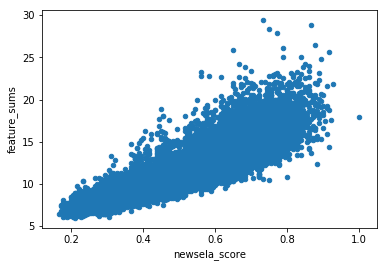

In [43]:
norm_df.plot.scatter(x="newsela_score",y="feature_sums")

In [44]:
norm_df.loc[norm_df["feature_sums"] > 30]

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums


## Apply Regression Model

* RidgeCV

In [107]:
norm_df = pd.read_csv("data/newsela_article_features.csv",sep=";")
norm_df["newsela_score"] = norm_df["newsela_score"].astype(float)

In [108]:
#feature_cols = norm_df.columns[2:-1]

In [45]:
def train_eval_model(train,test,model_fn):
    model = model_fn()
    
    feature_cols = list(train.columns)
    feature_cols.remove("newsela_score")
    
    model.fit(train[feature_cols],train["newsela_score"])
    
    print("Evaluation: \n Feature Importance:")
        
    for row in zip(*[train.columns,model.coef_]):
        print(row)
    print("Train Accuracy: ")
    print(model.score(train[feature_cols],
                    train["newsela_score"]))
    print("Test Accuracy: ")
    print(model.score(test[feature_cols],
                    test["newsela_score"]))
    
    return model

In [46]:
def eval_exclude_cols(df,feature_cols,exclude,test,model_fn):
    col_without = feature_cols
    bool_without = [col not in exclude for col in col_without]
    col_without = col_without[bool_without]
    #print(col_without,bool_without)
    train = df[["newsela_score"] + list(col_without)]
    
    return train_eval_model(
        train,test,model_fn)

In [50]:
y_bins = np.digitize(norm_df["newsela_score"]*1800, np.linspace(0,1,50))
y_bins[-1] = np.sort(y_bins)[-2]

In [51]:
#Test and Training Set
train,test = train_test_split(
    norm_df[["newsela_score"] + list(ts.feature_names)],
    stratify=y_bins,
    test_size=0.2,
    random_state=0)

R2 Coefficient: 0.949281521816607


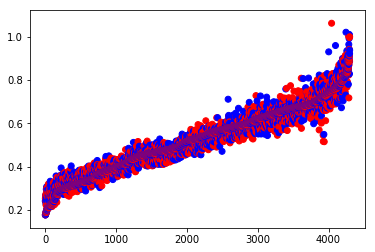

In [52]:
test_sorted = test.sort_values("newsela_score")
model = linear_model.RidgeCV()
model.fit(train[ts.feature_names],train["newsela_score"])
predictions = model.predict(test_sorted[ts.feature_names])
plt.scatter(
    x=[range(len(test)),range(len(test))],
    y=[predictions,test_sorted["newsela_score"]],
    c=["blue","red"])

print("R2 Coefficient: {}".format(
    model.score(test[ts.feature_names],test['newsela_score'])))

In [55]:
model.predict(norm_df.loc[norm_df["name"] == "dog-brain-scan"][ts.feature_names])*1800

array([1453.18810841,  858.33491102,  944.12829756, 1177.3974215 ,
        630.78829706])

In [56]:
norm_df.loc[norm_df["name"] == "dog-brain-scan"]["newsela_score"]*1800

3892     1320.0
10267     860.0
10566     980.0
17290    1170.0
17598     550.0
Name: newsela_score, dtype: float64

### All Attributes

In [57]:
norm_df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
0,/data/ts_cost_function/clean_newsela/kea-extin...,kea-extinction,21935,0.300000,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,...,0.603422,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116,7.687178
1,/data/ts_cost_function/clean_newsela/australia...,australia-sharks-drones,38904,0.772222,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,...,1.234272,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305,16.690378
2,/data/ts_cost_function/clean_newsela/city-trol...,city-trolley,10561,0.322222,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,...,0.360741,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794,8.278258
3,/data/ts_cost_function/clean_newsela/parkland-...,parkland-students-tony-awards,44221,0.566667,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,...,1.106273,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251,12.440091
4,/data/ts_cost_function/clean_newsela/nyc-elect...,nyc-election,1720,0.466667,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,...,0.551202,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627,9.679800


In [58]:
#RidgeCV
model = eval_exclude_cols(
    train,
    np.array(ts.feature_names),
    [],
    test,
    linear_model.RidgeCV
)

Evaluation: 
 Feature Importance:
('newsela_score', 0.3935641074608592)
('Mean word length', 0.722295274390144)
('Mean sentence length', -0.1487757676292502)
('Basic english ratio', -0.40767445786063694)
('Syllables per sentence', -0.05000802991651543)
('Type token ratio', 0.11054778770602103)
('#nouns', 0.07535225250204236)
('#verbs', 0.03514014812635591)
('#adjectives', 0.02928413884508929)
('#adverbs', -0.009701784998465635)
('#pronouns', 0.037030318995820655)
('Subordination', 0.0067653040510122775)
('Complements', 0.033162578581088065)
('Coordination', -0.003686813957501922)
('Apposition', -0.0058717679188534655)
('Passive verbs', 0.001284720914080495)
('Parataxis', 0.012673032687013475)
('Auxiliary Verbs', -0.009849909849285687)
('Negation', 0.02877578216512222)
('Prepositional Phrases', 0.019285124087639938)
Train Accuracy: 
0.9489178362500539
Test Accuracy: 
0.949281521816607


In [59]:
norm_df["regression_score"] = model.predict(norm_df[ts.feature_names])

In [61]:
norm_df[["path","feature_sums","regression_score"]+ts.feature_names].to_csv(
    "/data/ts_cost_function/newsela_article_feature_scores_V2.csv",
    sep=";",
    index=False)

### Weebit Data

In [113]:
weebit_df = pd.read_csv("data/weebit_articles_features.csv",sep=";")
weebit_df["regression_score"] = model.predict(weebit_df[ts.feature_names])
weebit_df["feature_sums"] = weebit_df[ts.feature_names].sum(axis=1)

In [114]:
weebit_df["group"] = [row[3] for row in weebit_df["path"].str.split("/")]

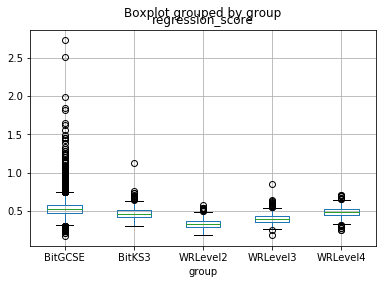

In [132]:
weebit_df.loc[
    (weebit_df["regression_score"] < 10)
].boxplot(column="regression_score",by="group")

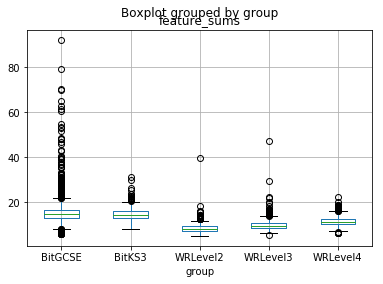

In [135]:
weebit_df.loc[
    #weebit_df["path"].str.contains("WRL") &
    (weebit_df["feature_sums"] < 100)].boxplot(column="feature_sums",by="group")

In [140]:
#which texts have a really high regression score?
high_value_df = weebit_df.loc[
    (weebit_df["regression_score"] > 1.5) &
    (weebit_df["regression_score"] < 2)]

In [142]:
for ind,row in high_value_df.iterrows():
    with open(row["path"],"r") as f:
        print(f.read())

Addition, subtraction, multiplication and division - Foundation
Addition, subtraction, multiplication and division - Foundation
yourself on Addition, subtraction, multiplication and division - Foundation
Addition, subtraction, multiplication and division - Higher
Addition, subtraction, multiplication and division - Higher
yourself on Addition, subtraction, multiplication and division - Higher
yourself on Converting fractions, decimals and percentages
yourself on Powers and roots - Foundation
yourself on Powers and roots - Higher

Moniza Alvi: Presents from my Aunts in Pakistan
Moniza Alvi: Presents from my Aunts in Pakistan
on Moniza Alvi: Presents from my Aunts in Pakistan
on Nissim Ezekiel: Night of the Scorpion
yourself on Nissim Ezekiel: Night of the Scorpion
Lawrence Ferlinghetti: Two Scavengers in a Truck...
Lawrence Ferlinghetti: Two Scavengers in a Truck...
on Lawrence Ferlinghetti: Two Scavengers in a Truck...
yourself on Lawrence Ferlinghetti: Two Scavengers in a Truck...
Suj

#### Exclude Articles with a score higher than 1.0

In [160]:
weebit_df = weebit_df.loc[
    (weebit_df["regression_score"] < 1.0)]

## Feature Correlation

In [6]:
norm_df = pd.read_csv("/data/ts_cost_function/newsela_article_feature_scores_V2.csv",sep=";")

### Plot Correlation Matrix

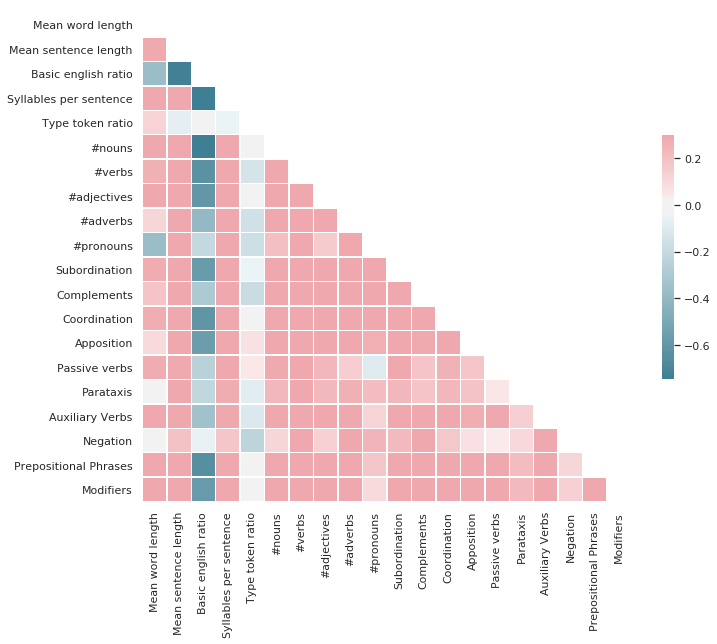

In [7]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = norm_df[ts.feature_names]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Save Scores for each text

In [161]:
final_weebit_df = weebit_df[["path"]+ts.feature_names]
final_newsela_df = norm_df[["path"]+ts.feature_names]


In [162]:
final_newsela_df["dataset"] = "newsela"
final_weebit_df["dataset"] = "weebit"



/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [164]:
dataset_df = pd.concat([final_newsela_df,final_weebit_df])
dataset_df.to_csv("data/dataset.csv",sep=";",index=False)

In [121]:
with open("models/ridgeCV.pkl","wb") as f:
    pickle.dump(model,f)

In [373]:
with open("models/ridgeCV.pkl","rb") as f:
    loaded_model = pickle.load(f)

In [374]:
loaded_model

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

## Check Dataset Values

In [180]:
for column in dataset_df.columns:
    print(f"NaN Rows in {column}: {sum(dataset_df[column].isna())}")
    if column in ts.feature_names:
        print(f"Finite Rows in {column}: {sum(~np.isfinite(dataset_df[column]))}")

NaN Rows in path: 0
NaN Rows in Mean word length: 0
Finite Rows in Mean word length: 0
NaN Rows in Mean sentence length: 0
Finite Rows in Mean sentence length: 0
NaN Rows in Basic english ratio: 0
Finite Rows in Basic english ratio: 0
NaN Rows in Syllables per sentence: 0
Finite Rows in Syllables per sentence: 0
NaN Rows in Type token ratio: 0
Finite Rows in Type token ratio: 0
NaN Rows in #nouns: 0
Finite Rows in #nouns: 0
NaN Rows in #verbs: 0
Finite Rows in #verbs: 0
NaN Rows in #adjectives: 0
Finite Rows in #adjectives: 0
NaN Rows in #adverbs: 0
Finite Rows in #adverbs: 0
NaN Rows in #pronouns: 0
Finite Rows in #pronouns: 0
NaN Rows in #commas: 0
Finite Rows in #commas: 0
NaN Rows in Subordination: 0
Finite Rows in Subordination: 0
NaN Rows in Complements: 0
Finite Rows in Complements: 0
NaN Rows in Coordination: 0
Finite Rows in Coordination: 0
NaN Rows in Apposition: 0
Finite Rows in Apposition: 0
NaN Rows in Passive verbs: 0
Finite Rows in Passive verbs: 0
NaN Rows in Parataxis: